In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Fake News Detection Dataset/PreProcessedDS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42384 entries, 0 to 42383
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        42331 non-null  object
 1   label       42384 non-null  int64 
 2   clean_news  42328 non-null  object
dtypes: int64(1), object(2)
memory usage: 993.5+ KB


In [ ]:
df.dropna(subset=['clean_news'], inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42328 entries, 0 to 42327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        42328 non-null  object
 1   label       42328 non-null  int64 
 2   clean_news  42328 non-null  object
dtypes: int64(1), object(2)
memory usage: 992.2+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.head()

,text,label,clean_news
0,Donald Trump just couldn t wish all Americans ...,0,donald trump wish american happy new year leav...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,friday revealed former milwaukee sheriff david...
3,"On Christmas day, Donald Trump announced that ...",0,christmas day donald trump announced would bac...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used annual christmas day message...


In [ ]:
df['clean_news'].shape

(42328,)

**Create Word Embeddings**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
# convert data-text into single word
tokenizer.fit_on_texts(df['clean_news'])
# word_index(Vocabulary of corpus) a dictionary with word and their index
word_index = tokenizer.word_index
print('Total Unique words are ',len(word_index))

Total Unique words are  215390


In [ ]:
# padding data to make all text rows with same length
sequences = tokenizer.texts_to_sequences(df['clean_news'])
# padding='post' - to make same length text(news) adding extra 0 at end of the text
# truncating='post' -(default) after making len of 10000 truncate those words whose has more len than 10000 at end
padded_seq = pad_sequences(sequences, maxlen=10000, padding='post')

In [ ]:
# Create embedding index
# a dictionary - key as word, value as vector form of that word
embedding_index = {}
with open('/content/drive/MyDrive/Fake News Detection Dataset/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        arr = line.split()
        word = arr[0]
        coefs = np.asarray(arr[1:], dtype='float32')
        embedding_index[word] = coefs


In [ ]:
len(embedding_index)

400000

In [ ]:
# Create embedding matrix
# 2D array - every word which comes in Vocabulary(word_index- word with index) are coverted into vector form and saved.
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, index in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(215391, 100)

In [ ]:
embedding_matrix[1]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

In [ ]:
padded_seq.shape

(42328, 10000)

In [ ]:
padded_seq[0]

array([  14,    2, 1744, ...,    0,    0,    0], dtype=int32)

# Splitting DataFrame

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting datasets into Train and Test
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.2, random_state=42, stratify=df['label'])
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(33862, 10000) (8466, 10000)
(33862,) (8466,)


# Model Building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([
# input_dim - vocabulary size, output_dim - sequence_length of word after vectorize, weights-pre
# vectorize word values (vocabulary_size, embedding_dimension), mask_zero - extra zeroes are dropped not counted
# input_shape - no of words in 1 row
    Embedding(input_dim=len(word_index)+1, output_dim=100, weights=embedding_matrix ,mask_zero=True, input_shape=(10000, )),
# return seq - True - for 2 consecutive LSTM layer
    LSTM(units=512, return_sequences=True, activation='tanh'),
    LSTM(units=256, activation='tanh'),
    Dropout(rate=0.2),
# activation - binary classification problem only check probability about news that is fake or True
    Dense(units=128, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid')
    ])

model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10000, 100)          │      21,539,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10000, 512)          │       1,255,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,615,005 (90.08 MB)

 Trainable params: 23,615,005 (90.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 129s 145ms/step - accuracy: 0.8975 - loss: 0.2424 - val_accuracy: 0.9584 - val_loss: 0.1233
Epoch 2/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 138s 145ms/step - accuracy: 0.9870 - loss: 0.0396 - val_accuracy: 0.9972 - val_loss: 0.0102
Epoch 3/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9979 - val_loss: 0.0079
Epoch 4/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9969 - val_loss: 0.0099
Epoch 5/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 122s 144ms/step - accuracy: 0.9971 - loss: 0.0087 - val_accuracy: 0.9968 - val_loss: 0.0132
Epoch 6/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.9982 - loss: 0.0081 - val_accuracy: 0.9978 - val_loss: 0.0082
Epoch 7/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.9998 - loss: 7.2559e-04 - val_accuracy: 0.9965 - val_loss: 0.0202
Epoch 8/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 142s 144ms/step - accuracy: 1.00

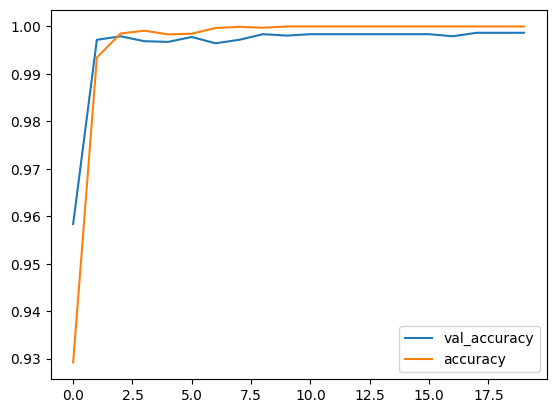

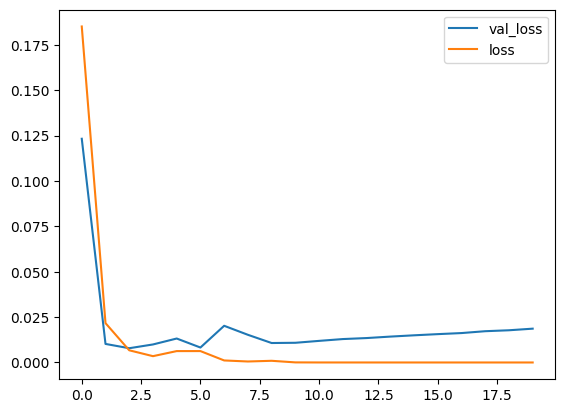

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:
path = '/content/drive/My Drive/Model/Fake_News_Detection_LSTM_MODEL.h5'
model.save(path)

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/drive/My Drive/Model/Fake_News_Detection_LSTM_MODEL.h5')

In [ ]:
y_test_predict = model.predict(x_test)

y_test_predict = np.where(y_test_predict < 0.5, 0, 1)
y_test_predict = y_test_predict.reshape(y_test_predict.shape[0])
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_predict)
# Test Accuracy

265/265 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step


0.9991731632412001

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4227
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      8466
   macro avg       1.00      1.00      1.00      8466
weighted avg       1.00      1.00      1.00      8466



In [ ]:
# text = ["Trump achieved victory in the Electoral College, winning 312 electoral votes to Harris' 226. Trump won every swing state in addition to holding on to all of the states that he won in 2020.[37][38] Trump flipped six states that had voted Democratic in 2020: Arizona, Georgia, Michigan, Nevada, Pennsylvania, and Wisconsin.[39] Trump won the national popular vote with 49.8%,[40][needs update?] making him the first Republican to do so since George W. Bush in 2004."]
# text =["The Sambhal Shahi Jama Masjid Committee has approached the Supreme Court challenging the order passed by a trial court for the commission survey of the mosque in a suit which alleged that it was built after destroying a temple. A bench comprising Chief Justice of India Sanjiv Khanna and Justice Sanjay Kumar will hear the matter tomorrow. Last week, Civil Judge (Senior Division) of Sambhal passed an ex-parte order for a survey of the mosque by an advocate commissioner. The plaintiffs claimed th https://www.livelaw.in/top-stories/sambhal-jama-masjid-committee-approaches-supreme-court-against-survey-order-cji-led-bench-to-hear-tomorrow-276666"]
# text = ["Speaking out for the first time since the fall of her government on August 5, Awami League Leader and former Prime Minister Sheikh Hasina on Thursday (November 28, 2024) called for the release of an ISKCON leader arrested by the authorities in Bangladesh ‘without delay’. In a statement issued by the Awami League, Ms. Hasina condemned the murder of an assistant public prosecutor in communal clashes in Chittagong that erupted on Tuesday, and called upon the people of Bangladesh to confront the Muhammad Yunus-led interim government in a “united” manner."]
# text = ['student on war.']
# text = ["""In the build-up to Tuesday’s US election, claims of voter fraud flooded social media - but as Donald Trump’s victory crystallised, the chatter largely subsided. The claims didn’t stop entirely, however. A number of right-wing influencers and organisations pushing stories about “cheating” and a “rigged” vote pointed to incomplete vote totals and continued to repeat discredited theories about the 2020 election.

# And disappointed Democratic Party supporters developed their own unsubstantiated voter fraud theories, some of which went viral on X, formerly Twitter, and other platforms.

# The reach of the posts is nowhere near the deluge of content that circulated after Trump lost the 2020 election.

# And with no support from losing candidate Kamala Harris or other Democratic Party officials, the chances seem slim of a large-scale movement developing along the lines of the “Stop the Steal” drive four years ago, which culminated in a riot at the US Capitol."""]

# text = ["""In an interaction with Economic Times (ET), GitHub chief executive officer Thomas Dohmke said, “If India would slow down next year for whatever reason…, those numbers are often also dependent on things out of our control.” Dohmke added, “The overall economic environment, the demand global system integrators are seeing, the startup ecosystem, how many students come out of the colleges in the next year, the year, those (students) started in the middle of Covid... So, there are a lot of factors playing into these models.” Dohmke visited India twice this year.
# While India's developer base continues to grow significantly, reaching 17 million in 2023, the US market, with 23.8 million developers, remains the largest. GitHub's CEO, Thomas Dohmke, expressed optimism about India's long-term potential, highlighting the country's strong startup ecosystem, growing number of tech graduates, and government support for technology initiatives."""]

text = ["""unbelievable russia collusion scam going month finger pointing everywhere trump team member specifically jared kushner donald trump jr defending meeting russian lawyer others long know nothing even cnn prof yes cnn believe itvia newsmaxthe controversial june 2016 meeting trump tower russian donald trump jr others indeed magnitsky act dishing dirt hillary clinton cnn reporteddocuments provided cnn back trump jr account jared kushner meeting insignificant waste timean attorney russian billionaire requested meeting provided document cnn suggested mixup originated publicist brokered meet greet trump jr kushner member president donald trump campaignthe attorney scott balber told cnn publicist rob goldstone probably exaggerated maybe willfully contorted fact purpose making meeting interesting trump people seed russia collusion story born cnn reported document consistent client understanding purpose meeting beginning time thereafter effort launch legislative review magnitsky act balber told cnngoldstone knew trump 2013 miss universe pageant moscow client performed pageant"""]

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

text[0] = text[0].lower()

import re
def remove_url(text_data):
  """remove_url takes raw text and removes urls from the text.
     https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
     """
  return re.sub(r"http\S+", "", text_data)

text[0] = remove_url(text[0])

# Download NLTK stopwords
nltk.download('stopwords')

# Load stopwords
stop = stopwords.words('english')

# Example text (for demonstration purposes)
# text = ["Hello, this is a test! \n This should be cleaned up..."]

# Perform cleaning operations on the first element of the list (text[0])
text[0] = re.sub(r'[^A-Za-z0-9\s]', '', text[0])  # Remove non-alphanumeric characters using regex
text[0] = text[0].replace('\n', '')  # Replace newlines with spaces
text[0] = re.sub(r'\s+', ' ', text[0])  # Replace multiple spaces with a single space

# Remove stopwords
text[0] = " ".join([word for word in text[0].split() if word.lower() not in stop])


# Lemmatization:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')

def lemmatization(words):
  wl = WordNetLemmatizer()
  lemma_words = []
  for i in words:
  # applying Lemmatization
    lemma_words.append(wl.lemmatize(i))

  return " ".join(lemma_words)

# converting text into tokens of word like 'donald trump wish american' to ['donald', 'trump', 'wish', 'american']
tokens = word_tokenize(text[0])
text[0] = lemmatization(tokens)

# Output the cleaned text
# print(text[0])


from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
# convert data-text into single word
tokenizer.fit_on_texts(text)
# word_index(Vocabulary of corpus) a dictionary with word and their index
word_index = tokenizer.word_index
# print('Total Unique words are ',len(word_index))

# padding data to make all text rows with same length
sequences = tokenizer.texts_to_sequences(text)
# padding='post' - to make same length text(news) adding extra 0 at end of the text
# truncating='post' -(default) after making len of 10000 truncate those words whose has more len than 10000 at end
padded_seq_New = pad_sequences(sequences, maxlen=10000, padding='post')

# padded_seq_New.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
new_prediction = model.predict(padded_seq_New)
if new_prediction[0][0]<0.5 :
  print('Fake')
else:
  print('True')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[1.1322134e-05]], dtype=float32)